# Module 7: Capstone Project - Band Gap Prediction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NabKh/ML-for-Materials-Science/blob/main/Tutorial-07-ML-Discovery/notebooks/07_project_bandgap.ipynb)

---

## 🎯 Project Goal

Build an **end-to-end ML pipeline** to predict band gaps of inorganic materials!

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #10b981;">

**The Band Gap**: The energy difference between the valence band maximum (VBM) and conduction band minimum (CBM). It determines whether a material is:
- **Metal**: $E_g = 0$ eV (no gap)
- **Semiconductor**: $0 < E_g < 4$ eV
- **Insulator**: $E_g > 4$ eV

</div>

### 📖 What You'll Apply

| Module | Concept | Application |
|--------|---------|-------------|
| **Module 1** | ML Fundamentals | Train/test split, cross-validation |
| **Module 2** | Data Foundation | Materials Project API, data cleaning |
| **Module 3** | Featurization | Magpie features from compositions |
| **Module 4** | Classical ML | Random Forest, Gradient Boosting |
| **Module 5** | Evaluation | R², MAE, learning curves |
| **Module 6** | Explainability | SHAP for feature importance |

---

**⏱️ Estimated time: 90 minutes** | **📚 Difficulty: 🔴 Advanced**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Materials science libraries
from pymatgen.core import Composition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

# SHAP for explainability
try:
    import shap
    HAS_SHAP = True
except:
    HAS_SHAP = False

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'

# Color palette for consistent styling
COLORS = {
    'primary': '#6366f1',    # Indigo
    'secondary': '#ec4899',  # Pink
    'success': '#10b981',    # Green
    'warning': '#f59e0b',    # Orange
    'info': '#0ea5e9',       # Sky blue
    'text': '#1e293b',       # Dark slate
}

np.random.seed(42)
print("✅ Ready for the capstone project!")

✅ Ready for the capstone project!


---

## Step 1: Load or Create Dataset

### 📖 Understanding Band Gap Data

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #6366f1;">

**Where does band gap data come from?**

1. **Experiments**: Optical spectroscopy, photoluminescence
2. **DFT Calculations**: Materials Project, AFLOW, OQMD databases

**DFT Band Gap Limitations:**
- Standard DFT (GGA/PBE) typically **underestimates** band gaps by 30-50%
- Hybrid functionals (HSE06) are more accurate but expensive
- ML can learn corrections on top of DFT values!

</div>

### 🔢 Band Gap Formula (Simplified)

For a direct band gap semiconductor:

$$E_g = E_{\text{CBM}} - E_{\text{VBM}}$$

Where:
- $E_{\text{CBM}}$ = Conduction Band Minimum energy
- $E_{\text{VBM}}$ = Valence Band Maximum energy

### 📊 Typical Band Gaps by Material Class

| Material Class | Example | Band Gap (eV) |
|---------------|---------|---------------|
| Wide-gap oxides | SiO₂, Al₂O₃ | 8-9 |
| III-V semiconductors | GaAs | 1.4 |
| II-VI semiconductors | ZnO | 3.3 |
| Halide perovskites | CsPbBr₃ | 2.3 |
| Transition metal dichalcogenides | MoS₂ | 1.8 |

In [2]:
# Try to load pre-built dataset, or create synthetic one
try:
    df = pd.read_csv('../data/sample_datasets/materials_bandgap.csv')
    print(f"✅ Loaded dataset: {len(df)} materials")
except:
    # Create realistic synthetic dataset
    print("Creating synthetic dataset...")
    
    formulas = [
        # Oxides (typically wide band gap)
        'SiO2', 'Al2O3', 'MgO', 'ZnO', 'TiO2', 'SnO2', 'CeO2', 'ZrO2',
        'Fe2O3', 'Cr2O3', 'V2O5', 'WO3', 'MoO3', 'NiO', 'CuO', 'CoO',
        # Nitrides
        'GaN', 'AlN', 'InN', 'BN', 'Si3N4', 'TiN',
        # Sulfides  
        'ZnS', 'CdS', 'PbS', 'MoS2', 'WS2', 'FeS2',
        # Semiconductors
        'GaAs', 'InP', 'InAs', 'GaP', 'InSb', 'GaSb',
        # Perovskites
        'CaTiO3', 'SrTiO3', 'BaTiO3', 'PbTiO3', 'KNbO3',
        # Other
        'CaF2', 'MgF2', 'LiF', 'NaCl', 'KCl', 'ZnSe', 'CdTe'
    ]
    
    # Approximate band gaps (for demonstration)
    band_gaps = [
        8.9, 8.8, 7.8, 3.3, 3.2, 3.6, 3.2, 5.8,
        2.2, 3.4, 2.3, 2.6, 3.0, 3.7, 1.2, 2.4,
        3.4, 6.0, 0.7, 5.5, 5.0, 0.0,
        3.7, 2.4, 0.4, 1.8, 2.0, 0.9,
        1.4, 1.3, 0.4, 2.3, 0.2, 0.7,
        3.5, 3.2, 3.2, 3.0, 3.6,
        11.8, 10.8, 14.2, 8.5, 8.4, 2.7, 1.5
    ]
    
    df = pd.DataFrame({'formula': formulas, 'band_gap': band_gaps})
    print(f"✅ Created dataset: {len(df)} materials")

df.head(10)

✅ Loaded dataset: 1966 materials


,material_id,formula,composition,band_gap,formation_energy,energy_above_hull,density,volume,nelements,nsites,spacegroup,element_group
0,mp-11107,Ac2O3,Ac2 O3,3.5226,-3.737668,0.0,9.109130,91.511224,2,5,P-3m1,"frozenset({'O', 'Ac'})"
1,mp-32800,Ac2S3,Ac16 S24,2.2962,-2.493064,0.0,6.535149,1118.407852,2,40,I-42d,"frozenset({'S', 'Ac'})"
2,mp-1183115,AcAlO3,Ac1 Al1 O3,4.1024,-3.690019,0.0,8.728230,57.451413,3,5,Pm-3m,"frozenset({'Al', 'O', 'Ac'})"
3,mp-27972,AcBr3,Ac2 Br6,4.1033,-2.494519,0.0,5.679086,272.928947,2,8,P6_3/m,"frozenset({'Br', 'Ac'})"
4,mp-30274,AcBrO,Ac2 Br2 O2,4.2410,-3.396186,0.0,7.652290,140.139410,3,6,P4/nmm,"frozenset({'O', 'Br', 'Ac'})"
5,mp-27971,AcCl3,Ac2 Cl6,5.0865,-2.788094,0.0,4.724439,234.337108,2,8,P6_3/m,"frozenset({'Cl', 'Ac'})"
6,mp-30273,AcClO,Ac2 Cl2 O2,4.4451,-3.586422,0.0,7.156871,129.213203,3,6,P4/nmm,"frozenset({'Cl', 'O', 'Ac'})"
7,mp-866101,AcCrO3,Ac1 Cr1 O3,2.0031,-3.138972,0.0,8.848788,61.362845,3,5,Pm-3m,"frozenset({'Cr', 'O', 'Ac'})"
8,mp-861502,AcFeO3,Ac1 Fe1 O3,0.9888,-2.771539,0.0,8.889999,61.797311,3,5,Pm-3m,"frozenset({'Fe', 'O', 'Ac'})"
9,mp-1183053,AcGaO3,Ac1 Ga1 O3,2.8959,-3.063253,0.0,9.314495,61.455078,3,5,Pm-3m,"frozenset({'Ga', 'O', 'Ac'})"


## Step 2: Featurization

### 📖 Theory: Why Featurization Matters

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #f59e0b;">

**ML models can't read chemical formulas** - they need numerical features!

**Magpie Features** (132 features) include statistics of:
- Electronegativity
- Atomic radius
- Valence electrons
- Melting point
- And many more elemental properties...

For each property, we calculate: mean, std, min, max, range, mode

</div>

### 🔢 Example Feature Calculation

For a compound $A_xB_y$, the weighted mean electronegativity is:

$$\bar{\chi} = \frac{x \cdot \chi_A + y \cdot \chi_B}{x + y}$$

**Example: ZnO**
- Zn: $\chi = 1.65$, O: $\chi = 3.44$
- Mean: $\bar{\chi} = \frac{1 \times 1.65 + 1 \times 3.44}{2} = 2.545$

### ❓ Why These Features Work for Band Gap

| Feature | Physical Relationship to Band Gap |
|---------|----------------------------------|
| Electronegativity difference | Larger → More ionic → Larger gap |
| Mean atomic radius | Larger → Weaker bonding → Smaller gap |
| Valence electrons | More → More metallic → Smaller gap |
| Electronegativity (mean) | Higher → Stronger bonds → Larger gap |

In [3]:
# Convert formulas to compositions
print("Step 2: Featurization")
print("="*50)

# Remove composition column if it exists (allows re-running the cell)
if 'composition' in df.columns:
    df = df.drop(columns=['composition'])

stc = StrToComposition()
df = stc.featurize_dataframe(df, 'formula')
print("✓ Converted formulas to compositions")

# Apply ElementProperty featurizer
ep = ElementProperty.from_preset('magpie')

# Remove existing Magpie features if they exist (allows re-running)
existing_magpie_cols = [col for col in df.columns if col in ep.feature_labels()]
if existing_magpie_cols:
    df = df.drop(columns=existing_magpie_cols)

df = ep.featurize_dataframe(df, 'composition', ignore_errors=True)
print(f"✓ Generated {len(ep.feature_labels())} Magpie features")

# Clean up
df = df.dropna()
print(f"✓ Final dataset: {len(df)} materials, {df.shape[1]} columns")

Step 2: Featurization


StrToComposition:   0%|          | 0/1966 [00:00<?, ?it/s]

✓ Converted formulas to compositions


ElementProperty:   0%|          | 0/1966 [00:00<?, ?it/s]

✓ Generated 132 Magpie features
✓ Final dataset: 1966 materials, 144 columns


## Step 3: Train/Test Split

### 📖 Theory: Proper Data Splitting

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #ec4899;">

**Why split data?**
- Training set: Model learns patterns
- Test set: Evaluate generalization to unseen materials
- **Never use test data during training!**

**Common split ratios:**
- 80/20: More training data, good for small datasets
- 70/30: Larger test set for more reliable evaluation
- 60/20/20: With validation set for hyperparameter tuning

</div>

### 🔢 Standardization Formula

Features are standardized to have zero mean and unit variance:

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $x$ = original feature value
- $\mu$ = mean of training set (NOT all data!)
- $\sigma$ = standard deviation of training set

**⚠️ Important**: Fit scaler on training data only, then transform both train and test.

In [4]:
# Prepare features and target
feature_cols = ep.feature_labels()
X = df[feature_cols].values
y = df['band_gap'].values

# Handle any inf values
X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Training: {len(X_train)} | Test: {len(X_test)}")

Training: 1572 | Test: 394


## Step 4: Model Training and Comparison

### 📖 Theory: Model Selection for Materials Science

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #0ea5e9;">

**Which model to choose?**

| Model | Pros | Cons | Best For |
|-------|------|------|----------|
| **Ridge** | Fast, interpretable | Linear only | Baseline, few features |
| **Random Forest** | Non-linear, robust | Less interpretable | General purpose |
| **Gradient Boosting** | Often best accuracy | Slower, more tuning | When accuracy matters |

</div>

### 🔢 Model Formulas

**Ridge Regression** (L2 regularization):
$$\hat{\beta} = \arg\min_\beta \left( \|y - X\beta\|^2 + \alpha \|\beta\|^2 \right)$$

**Random Forest** prediction:
$$\hat{y} = \frac{1}{B} \sum_{b=1}^{B} T_b(x)$$

Where $T_b$ is the prediction of tree $b$, and $B$ is the number of trees.

**Gradient Boosting** prediction:
$$\hat{y} = \sum_{m=1}^{M} \gamma_m h_m(x)$$

Where $h_m$ are weak learners and $\gamma_m$ are learning rates.

In [5]:
# Define models
models = {
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
}

# Train and evaluate
results = []
best_model = None
best_r2 = -np.inf

print("\nModel Comparison:")
print("="*60)
print(f"{'Model':<20} {'Train R²':>10} {'Test R²':>10} {'Test MAE':>10}")
print("-"*60)

for name, model in models.items():
    model.fit(X_train_s, y_train)
    
    train_r2 = model.score(X_train_s, y_train)
    test_r2 = model.score(X_test_s, y_test)
    y_pred = model.predict(X_test_s)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    results.append({'Model': name, 'Train R²': train_r2, 'Test R²': test_r2, 'MAE': test_mae})
    print(f"{name:<20} {train_r2:>10.4f} {test_r2:>10.4f} {test_mae:>10.4f}")
    
    if test_r2 > best_r2:
        best_r2 = test_r2
        best_model = model
        best_name = name

print(f"\n✅ Best model: {best_name} (R² = {best_r2:.4f})")


Model Comparison:
Model                  Train R²    Test R²   Test MAE
------------------------------------------------------------
Ridge                    0.6074     0.5873     0.7021


Random Forest            0.9035     0.7962     0.4951


Gradient Boosting        0.9453     0.7880     0.4950

✅ Best model: Random Forest (R² = 0.7962)


## Step 5: Cross-Validation

### 📖 Theory: Why Cross-Validation Matters

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #10b981;">

**Problem**: A single train/test split can give misleading results due to random chance.

**Solution**: K-Fold Cross-Validation
1. Split data into K equal parts (folds)
2. Train on K-1 folds, test on the remaining fold
3. Repeat K times (each fold serves as test once)
4. Average the results

**Benefits:**
- Every sample is used for testing exactly once
- More reliable performance estimate
- Reveals variance in model performance

</div>

### 🔢 Cross-Validation Score

$$\text{CV Score} = \frac{1}{K} \sum_{k=1}^{K} \text{Score}_k \pm \sigma_{\text{folds}}$$

Where:
- $K$ = number of folds (typically 5 or 10)
- $\text{Score}_k$ = metric on fold $k$
- $\sigma_{\text{folds}}$ = standard deviation across folds

### ❓ Interpreting CV Results

| CV Std Dev | Interpretation |
|------------|----------------|
| < 0.02 | Very stable, reliable |
| 0.02 - 0.05 | Normal variation |
| > 0.05 | High variance, check data |

In [6]:
# 5-fold CV on best model
cv_scores = cross_val_score(
    RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    X, y, cv=5, scoring='r2'
)

print(f"5-Fold Cross-Validation:")
print(f"  Scores: {cv_scores.round(4)}")
print(f"  Mean:   {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

5-Fold Cross-Validation:
  Scores: [0.6017 0.7016 0.6139 0.5767 0.7228]
  Mean:   0.6434 ± 0.0579


## Step 6: Visualization

### 📖 Theory: The Parity Plot

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #6366f1;">

**Parity Plot**: The most important visualization in ML for materials science!

- X-axis: Actual (true) values
- Y-axis: Predicted values
- Diagonal line: Perfect predictions (y = x)
- Points on the line = Perfect predictions
- Scatter around line = Prediction error

</div>

### 🔢 Evaluation Metrics

**Coefficient of Determination (R²)**:
$$R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}$$

**Mean Absolute Error (MAE)**:
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

**Root Mean Squared Error (RMSE)**:
$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

### ❓ What's a Good Score for Band Gap Prediction?

| Metric | Excellent | Good | Needs Improvement |
|--------|-----------|------|-------------------|
| R² | > 0.90 | 0.70 - 0.90 | < 0.70 |
| MAE | < 0.3 eV | 0.3 - 0.5 eV | > 0.5 eV |

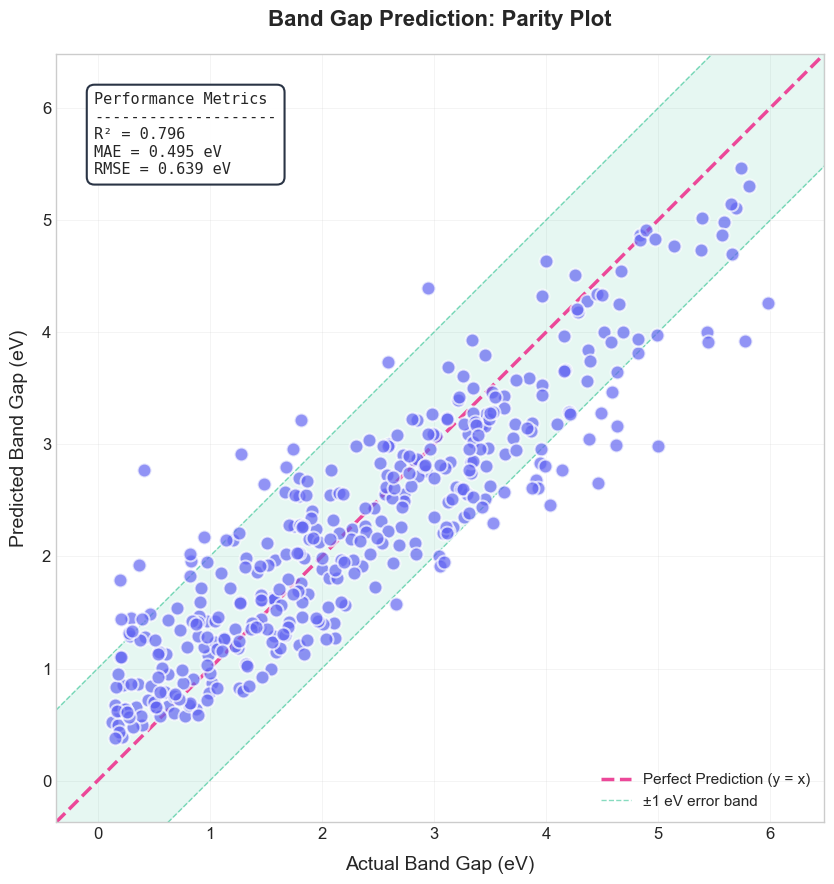


📊 Model Evaluation Summary
  R² Score:  0.7962
  MAE:       0.4951 eV
  RMSE:      0.6387 eV


In [7]:
# Parity plot with enhanced professional styling
y_pred = best_model.predict(X_test_s)

fig, ax = plt.subplots(figsize=(9, 9))

# Main scatter plot with improved aesthetics
scatter = ax.scatter(y_test, y_pred, 
                     c=COLORS['primary'], 
                     alpha=0.7, 
                     s=100, 
                     edgecolors='white', 
                     linewidth=1.5,
                     zorder=3)

# Perfect prediction line
lims = [min(y_test.min(), y_pred.min()) - 0.5, max(y_test.max(), y_pred.max()) + 0.5]
ax.plot(lims, lims, color=COLORS['secondary'], linewidth=2.5, 
        linestyle='--', label='Perfect Prediction (y = x)', zorder=2)

# Add ±1 eV error bands
ax.fill_between(lims, [l-1 for l in lims], [l+1 for l in lims], 
                alpha=0.1, color=COLORS['success'], zorder=1)
ax.plot(lims, [l+1 for l in lims], '--', color=COLORS['success'], 
        alpha=0.5, linewidth=1, label='±1 eV error band')
ax.plot(lims, [l-1 for l in lims], '--', color=COLORS['success'], 
        alpha=0.5, linewidth=1)

# Labels and title
ax.set_xlabel('Actual Band Gap (eV)', fontsize=14, labelpad=10)
ax.set_ylabel('Predicted Band Gap (eV)', fontsize=14, labelpad=10)
ax.set_title('Band Gap Prediction: Parity Plot', fontsize=16, fontweight='bold', pad=20)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')
ax.legend(loc='lower right', fontsize=11, framealpha=0.95)

# Add metrics box - moved to upper left (no overlap now since legend moved)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))

textstr = f'Performance Metrics\n' + '-'*20 + f'\nR² = {r2:.3f}\nMAE = {mae:.3f} eV\nRMSE = {rmse:.3f} eV'
props = dict(boxstyle='round,pad=0.5', facecolor='white', 
             edgecolor=COLORS['text'], alpha=0.95, linewidth=1.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace', bbox=props)

# Grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('figures/07_parity_plot.png', dpi=200, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

print("\n" + "="*50)
print("📊 Model Evaluation Summary")
print("="*50)
print(f"  R² Score:  {r2:.4f}")
print(f"  MAE:       {mae:.4f} eV")
print(f"  RMSE:      {rmse:.4f} eV")
print("="*50)

## Step 7: Model Interpretation with SHAP

### 📖 Theory: Understanding Your Model

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #f59e0b;">

**Why interpret the model?**

1. **Validate physics**: Does the model learn chemically meaningful patterns?
2. **Build trust**: Understand why predictions are made
3. **Find issues**: Detect if model relies on spurious correlations
4. **Gain insights**: Discover new structure-property relationships

**Expected important features for band gap:**
- Electronegativity-related features (positive effect)
- Valence electron features (negative effect)
- Atomic radius features (varies)

</div>

### ❓ Questions to Answer with SHAP

1. Which features most strongly influence band gap predictions?
2. Do high electronegativity values lead to higher band gaps? (Should be YES)
3. Do more valence electrons lead to lower band gaps? (Should be YES)
4. Are there any unexpected feature relationships?

Calculating SHAP values (this may take a moment)...


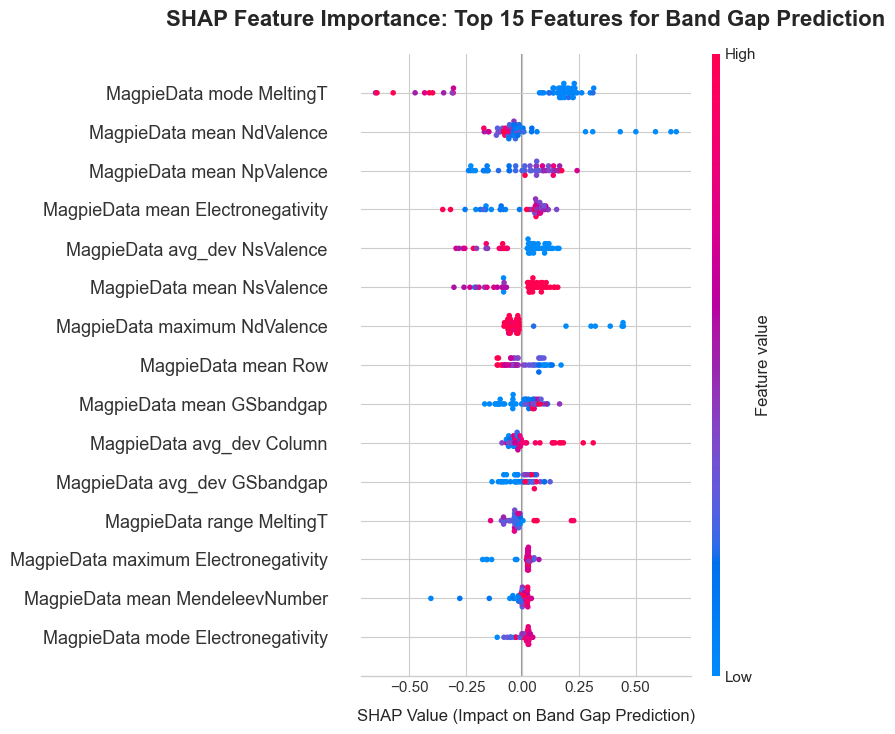


💡 Physical Validation Checklist
  Check if the model learned physically meaningful patterns:

  ✓ Electronegativity features should have POSITIVE effect
    (Higher χ → More ionic → Larger band gap)

  ✓ Valence electron features may have NEGATIVE effect
    (More electrons → More metallic → Smaller band gap)

  ✓ Atomic radius features often have NEGATIVE effect
    (Larger atoms → Weaker bonding → Smaller band gap)


In [8]:
if HAS_SHAP:
    # SHAP analysis with enhanced styling
    print("Calculating SHAP values (this may take a moment)...")
    explainer = shap.Explainer(best_model, X_train_s, feature_names=feature_cols)
    shap_values = explainer(X_test_s[:50])  # Use subset for speed
    
    # Summary plot with better styling
    fig = plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_values, X_test_s[:50], feature_names=feature_cols, 
                      max_display=15, show=False)
    plt.title('SHAP Feature Importance: Top 15 Features for Band Gap Prediction', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('SHAP Value (Impact on Band Gap Prediction)', fontsize=12, labelpad=10)
    plt.tight_layout()
    plt.savefig('figures/07_shap_summary.png', dpi=200, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()
    
    print("\n" + "="*60)
    print("💡 Physical Validation Checklist")
    print("="*60)
    print("  Check if the model learned physically meaningful patterns:")
    print("")
    print("  ✓ Electronegativity features should have POSITIVE effect")
    print("    (Higher χ → More ionic → Larger band gap)")
    print("")
    print("  ✓ Valence electron features may have NEGATIVE effect")
    print("    (More electrons → More metallic → Smaller band gap)")
    print("")
    print("  ✓ Atomic radius features often have NEGATIVE effect")
    print("    (Larger atoms → Weaker bonding → Smaller band gap)")
    print("="*60)
else:
    print("SHAP not available. Using Random Forest feature importance instead.")
    if hasattr(best_model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        # Enhanced feature importance plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, 15))[::-1]
        bars = ax.barh(range(len(importance)), importance['importance'], 
                       color=colors, edgecolor='white', linewidth=1.5)
        
        ax.set_yticks(range(len(importance)))
        ax.set_yticklabels(importance['feature'], fontsize=11)
        ax.invert_yaxis()
        
        ax.set_xlabel('Feature Importance', fontsize=12, labelpad=10)
        ax.set_title('Random Forest Feature Importance: Top 15 Features', 
                     fontsize=16, fontweight='bold', pad=20)
        
        # Add value labels
        for bar, val in zip(bars, importance['importance']):
            ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                    f'{val:.3f}', va='center', fontsize=10)
        
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig('figures/07_feature_importance.png', dpi=200, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        plt.show()
        
        print("\nTop 5 Most Important Features:")
        print(importance.head().to_string(index=False))

---

## 🎉 Project Complete!

### 📊 What You Built

<div style="background: rgba(16, 185, 129, 0.1); padding: 15px; border-radius: 10px; border-left: 4px solid #10b981;">

| Step | Task | Completed |
|------|------|-----------|
| 1 | Loaded/created materials dataset | ✅ |
| 2 | Featurized compositions with Magpie | ✅ |
| 3 | Properly split data (train/test) | ✅ |
| 4 | Trained and compared ML models | ✅ |
| 5 | Evaluated with cross-validation | ✅ |
| 6 | Visualized with parity plot | ✅ |
| 7 | Interpreted model with SHAP | ✅ |

</div>

### 🔢 Key Formulas Summary

| Concept | Formula |
|---------|---------|
| Band Gap | $E_g = E_{\text{CBM}} - E_{\text{VBM}}$ |
| R² Score | $R^2 = 1 - \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2}$ |
| MAE | $\text{MAE} = \frac{1}{n}\sum |y - \hat{y}|$ |
| Cross-Validation | $\text{CV} = \frac{1}{K}\sum_{k=1}^K \text{Score}_k$ |
| SHAP Efficiency | $\sum_i \phi_i = f(x) - E[f(x)]$ |

### 🎯 Self-Assessment Quiz

<div style="background: rgba(99, 102, 241, 0.1); padding: 15px; border-radius: 10px; border-left: 4px solid #6366f1;">

**Q1**: Why do we use Magpie features instead of raw formulas?  
**Q2**: What does a high train R² but low test R² indicate?  
**Q3**: Why is cross-validation better than a single train/test split?  
**Q4**: How do we validate that a model learned physically meaningful patterns?  

</div>

<details>
<summary>Click to reveal answers</summary>

**A1**: ML models need numerical inputs; Magpie converts formulas to statistics of elemental properties.  
**A2**: Overfitting - the model memorized training data but doesn't generalize.  
**A3**: CV provides more robust estimates by using all data for both training and testing.  
**A4**: Use SHAP to check if features like electronegativity have expected effects on predictions.

</details>

---

### 🚀 Extension Challenges

| Challenge | Difficulty | Description |
|-----------|------------|-------------|
| Add stoichiometry features | ⭐ | Include ValenceOrbital and Stoichiometry featurizers |
| Hyperparameter tuning | ⭐⭐ | Use GridSearchCV or Optuna for optimization |
| Classification | ⭐⭐ | Predict metal/semiconductor/insulator classes |
| Transfer learning | ⭐⭐⭐ | Pre-train on DFT, fine-tune on experimental data |
| Neural network | ⭐⭐⭐ | Implement an MLP or graph neural network |

---

## 🚀 What's Next?

Continue to **Tutorial 08: Neural Network Potentials** to learn about:

<div style="background: linear-gradient(135deg, #1e293b 0%, #0f172a 100%); padding: 20px; border-radius: 10px; border-left: 4px solid #0ea5e9;">

- **Graph Neural Networks** for materials (CGCNN, MEGNet)
- **Universal ML Potentials** (M3GNet, CHGNet, MACE)
- **Molecular Dynamics** with ML potentials
- **Structure-based predictions** beyond composition

</div>

---

### 📚 References

1. Ward, L. et al. (2016). A general-purpose machine learning framework for predicting properties of inorganic materials. *npj Computational Materials*, 2, 16028.
2. Lundberg, S.M. & Lee, S.I. (2017). A unified approach to interpreting model predictions. *NeurIPS*.
3. Materials Project: https://materialsproject.org